# BART Tutorial: Reproducing CG-SENSE

This notebook shows how to perform a CG-SENSE reconstruction on non-Cartesian data, going from a provided HDF5 file to reconstructed images. This is done on a dataset provided as part of the ISMRM Reproducible Research Study Group challenge to reproduce the results of Pruessmann et al. seminal paper "Advances in Sensitivity Encoding With Arbitrary k-Space Trajectories".

In [1]:
# Set the correct bart versions, if needed

#export TOOLBOX_PATH=/path/to/bart
#export PATH=$TOOLBOX_PATH:$PATH
#export PYTHONPATH="${TOOLBOX_PATH}/python:$PYTHONPATH"


# BASH function to write BART file to png,
# display the png, and remove it afterwards
function imshow () {
    bart toimg -W $1 $1.png > /dev/null
    cat $1.png | display
    rm $1.png
}
export -f imshow

# version without automatic windowing
function imshow_nowin () {
    bart toimg $1 $1.png > /dev/null
    cat $1.png | display
    rm $1.png
}
export -f imshow_nowin

function imshow_mult () {
    for i in "$@"; do
    bart toimg $i $i.png > /dev/null
    done
    COMBINED=$(mktemp --tmpdir=. tmpXXXXX.png)
    convert "${@/%/.png}" +append $COMBINED
    rm "${@/%/.png}"
    cat $COMBINED | display
    rm $COMBINED
    
}



In [2]:
bart version -V

v0.6.00-1-g1512f4d
GCC_VERSION=10.1.0
CUDA=0
ACML=0
FFTWTHREADS=1


## Download raw data

In [3]:
# Use curl instead of wget, for MacOS compatibility
curl --output data/rawdata_brain_radial_96proj_12ch.h5 'https://zenodo.org/record/3975887/files/rawdata_brain_radial_96proj_12ch.h5'
# Optional additional data, not used for now
#curl --output data/rawdata_heart_radial_55proj_34ch.h5 'https://zenodo.org/record/3975887/files/rawdata_heart_radial_55proj_34ch.h5'
#curl --output data/rawdata_spiral_ETH.h5 'https://zenodo.org/record/3975887/files/rawdata_spiral_ETH.h5'
#curl --output data/cardiac_radial_KI.h5 'https://zenodo.org/record/3975887/files/cardiac_radial_KI.h5'

(
cd data
md5sum --ignore-missing -c zenodo.md5
)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51.2M  100 51.2M    0     0  4227k      0  0:00:12  0:00:12 --:--:-- 4553k
rawdata_brain_radial_96proj_12ch.h5: OK


## Convert from HDF5 to BART .cfl format

Since BART does not natively support HDF5, we use a small python script to convert it. Note that a single HDF5 file contains multiple arrays/datasets. We create a .cfl file for each dataset in the HDF5.

In [4]:
# Show the entire conversion script:
cat data/02_hdf5_to_cfl.py
(
cd data
./02_hdf5_to_cfl.py
)

#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import h5py
import os
import os.path
import cfl


with os.scandir(os.path.curdir) as dirit:
    for f in dirit:
        prefix = 'rawdata_'
        if f.name.endswith(".h5"): 
            #remove rawdata_ prefix and .h5 extension
            if f.name.startswith(prefix):
                fstrip = f.name[len(prefix):-3]
            else:
                fstrip = f.name[:-3]
            h5_dataset = h5py.File(f, 'r')
            outdir = fstrip + "_cfl"
            os.makedirs(outdir, exist_ok=True)
            for key in list(h5_dataset.keys()):
                keydata = h5_dataset.get(key)[()]
                cfl.writecfl(os.path.join(outdir, key), keydata)


So, now the folder contains each of the datasets in .cfl format. Note that each .cfl dataset is made up of two files: one with the extension .cfl, containing the binary complex float data. And a .hdr file, which is a header describing the data layout.

In [5]:
ls data/brain_radial_96proj_12ch_cfl

Coils.cfl  InScale.cfl  mask.cfl  rawdata.cfl  trajectory.cfl
Coils.hdr  InScale.hdr  mask.hdr  rawdata.hdr  trajectory.hdr


## Convert to BART conventions

Having .cfl files is not all that is needed to easily work with bart. bart also has an opinion on what each dimension in a file means. The convention for image-space data is (abbreviated):

[X Y Z Coils ...]

for k-space data:

[1 Readout Lines Coils ...]

and for a trajectory:

[3 Readout Lines Coils ...]

So let's see what we have in the brain dataset:

In [6]:
bart show -m data/brain_radial_96proj_12ch_cfl/trajectory
# Very good, no changes needed

Type: complex float
Dimensions: 16
AoD:	3	512	96	1	1	1	1	1	1	1	1	1	1	1	1	1


In [7]:
bart show -m data/brain_radial_96proj_12ch_cfl/rawdata
# Same here

Type: complex float
Dimensions: 16
AoD:	1	512	96	12	1	1	1	1	1	1	1	1	1	1	1	1


In [8]:
bart show -m data/brain_radial_96proj_12ch_cfl/Coils
# Bad, coils as first dimension, this needs to change

Type: complex float
Dimensions: 16
AoD:	12	680	680	1	1	1	1	1	1	1	1	1	1	1	1	1


In [9]:
# Let's create a directory to work in
mkdir -p brain_reconstruction

# A bit more work is needed for the coils:
# Coils to the correct dimension
bart transpose 0 3 data/brain_radial_96proj_12ch_cfl/Coils brain_reconstruction/tmp_Coils 
# Resize to the same size as InScale
bart resize -c 1 300 2 300 brain_reconstruction/tmp_Coils brain_reconstruction/tmp_Coils2 
# X and Y in proper place
bart reshape $(bart bitmask 0 1 2) 300 300 1 brain_reconstruction/tmp_Coils2 brain_reconstruction/Coils 
bart show -m brain_reconstruction/Coils

Type: complex float
Dimensions: 16
AoD:	300	300	1	12	1	1	1	1	1	1	1	1	1	1	1	1


## Next, undersample k-space and trajectory
To undersample by a factor of N, we just pick each Nth line in the k-space and the trajectory.

For this, we have a small python script:

In [10]:
./undersample.py -h

usage: undersample.py [-h] D acc IN OUT

Undersample cfl

positional arguments:
  D           Dimension
  acc         Acceleration factor
  IN          Input cfl
  OUT         Output cfl

optional arguments:
  -h, --help  show this help message and exit


In [11]:
# Factor 1, no undersampling
./undersample.py 2 1 data/brain_radial_96proj_12ch_cfl/rawdata brain_reconstruction/rawdata_1
./undersample.py 2 1 data/brain_radial_96proj_12ch_cfl/trajectory brain_reconstruction/traj_1
# Factor 2
./undersample.py 2 2 data/brain_radial_96proj_12ch_cfl/rawdata brain_reconstruction/rawdata_2
./undersample.py 2 2 data/brain_radial_96proj_12ch_cfl/trajectory brain_reconstruction/traj_2

bart show -m brain_reconstruction/rawdata_1
bart show -m brain_reconstruction/rawdata_2

Type: complex float
Dimensions: 16
AoD:	1	512	96	12	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	1	512	48	12	1	1	1	1	1	1	1	1	1	1	1	1


### ... and calculate the Ram-Lak Filter
In bart, this can be done from the trajectory, as it contains the k-space position. A Ram-Lak filter scales data from 0 to 1 depending on the distance from the k-space center. Note that the Ram-Lak filter is only sensible for radial, and there it is only accurate for dense sampling. For stronger undersampling, it is an inaccurate estimation of the sampling density.

So it can be calculated as:

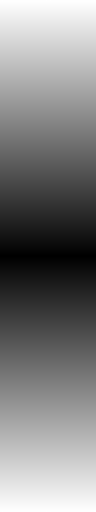

In [12]:
bart rss 1 brain_reconstruction/traj_1 brain_reconstruction/tmp_rl_1
imshow_nowin brain_reconstruction/tmp_rl_1
# but it needs to be rescaled, as the trajectory is scaled from -FOV/2 to FOV/2
rl_scale=$(echo "2/300" | bc -l)
bart scale $rl_scale brain_reconstruction/tmp_rl_1 brain_reconstruction/rl_1
# But we need the square root of the Ram-Lak
bart spow 0.5 brain_reconstruction/rl_1 brain_reconstruction/sqrt_rl_1


# And the same for undersampling 2
bart rss 1 brain_reconstruction/traj_2 brain_reconstruction/tmp_rl_2
bart scale $rl_scale brain_reconstruction/tmp_rl_2 brain_reconstruction/rl_2
# But we need the square root of the Ram-Lak
bart spow 0.5 brain_reconstruction/rl_2 brain_reconstruction/sqrt_rl_2

### Reconstruction

First, an adjoint nufft with the Ram-Lak applied:

Est. image size: 300 300 1
Done.
Est. image size: 300 300 1
Done.
Type: complex float
Dimensions: 16
AoD:	300	300	1	12	1	1	1	1	1	1	1	1	1	1	1	1


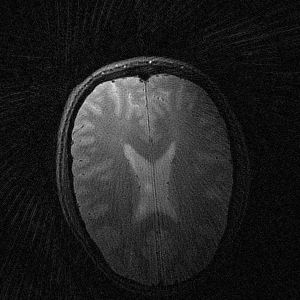

In [13]:
bart fmac brain_reconstruction/rl_1 brain_reconstruction/rawdata_1 brain_reconstruction/rawdata_rl_1
bart nufft -a brain_reconstruction/traj_1 brain_reconstruction/rawdata_rl_1 brain_reconstruction/nufft_adj_1

bart fmac brain_reconstruction/rl_2 brain_reconstruction/rawdata_2 brain_reconstruction/rawdata_rl_2
bart nufft -a brain_reconstruction/traj_2 brain_reconstruction/rawdata_rl_2 brain_reconstruction/nufft_adj_2

# and let's look at the first image:
bart show -m brain_reconstruction/nufft_adj_1
bart slice 3 0 brain_reconstruction/nufft_adj_1 brain_reconstruction/nufft_adj_1_Coil0

imshow_nowin brain_reconstruction/nufft_adj_1_Coil0

As happens so often, the dataset is rotated or flipped. So we have to undo this:

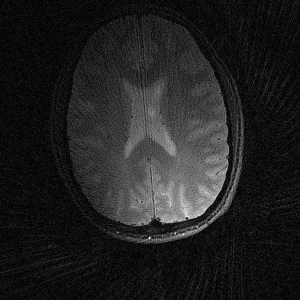

In [14]:
# Wrong image orientation!
bart flip $(bart bitmask 0 1 2) brain_reconstruction/nufft_adj_1_Coil0 brain_reconstruction/nufft_adj_1_Coil0_flip

imshow_nowin brain_reconstruction/nufft_adj_1_Coil0_flip

Now, to actually solve the parallel imaging problem, we use pics:

pics is the general "parallel imaging/compressed sensing" tool and as such has quite a few options and parameters. Take a look if you dare:

In [15]:
# bart pics -h

bart pics options that are important for now:
```
bart pics [...] <kspace> <sensitivities> <output>

-R <T>:A:B:C	generalized regularization options (-Rh for help)
-i iter      	max. number of iterations
-t file      	k-space trajectory
-p file      	pattern or weights
-T file      	(truth file)
-d level      	Debug level
-w val      	inverse scaling of the data
-S		re-scale the image after reconstruction
-h		help
```

In [16]:
bart pics -Rh

Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet domain
-R F:A:B:C	l1-Fourier
-R T:A:B:C	total variation
-R T:7:0:.01	3D isotropic total variation with 0.01 regularization.
-R L:7:7:.02	Locally low rank with spatial decimation and 0.02 regularization.
-R M:7:7:.03	Multi-scale low rank with spatial decimation and 0.03 regularization.


[  1 512  96  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
[300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512  96  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 49152 (vs. 409152) + 360000
ksp : [  1 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1

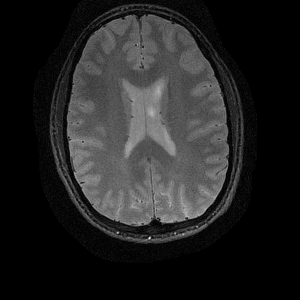

In [17]:
bart pics -d5 -p brain_reconstruction/sqrt_rl_1 -RQ:0.1 -t brain_reconstruction/traj_1 \
    brain_reconstruction/rawdata_1 brain_reconstruction/Coils \
    brain_reconstruction/recon_pics_1 

bart flip 7 brain_reconstruction/recon_pics_1 brain_reconstruction/recon_pics_1_flip
imshow_nowin brain_reconstruction/recon_pics_1_flip

[  1 512  96  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
[300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512  96  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 49152 (vs. 409152) + 360000
ksp : [  1 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1

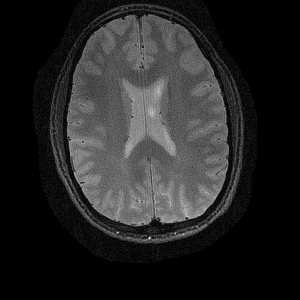

In [18]:
# reconstruct with a single CG iteration
bart pics -i1 -d5 -p brain_reconstruction/sqrt_rl_1 -RQ:0.1 -t brain_reconstruction/traj_1 \
brain_reconstruction/rawdata_1 brain_reconstruction/Coils \
brain_reconstruction/recon_pics_1_it1

bart flip 7 brain_reconstruction/recon_pics_1_it1 brain_reconstruction/recon_pics_1_it1_flip
imshow_nowin brain_reconstruction/recon_pics_1_it1_flip


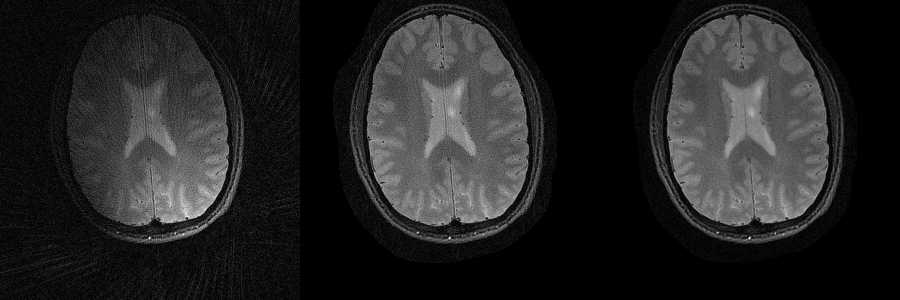

In [19]:
# Show together to create first line of the output figure:
imshow_mult brain_reconstruction/{nufft_adj_1_Coil0_flip,recon_pics_1_it1_flip,recon_pics_1_flip}

For the undersampling factor of two, we can use the final reconstruction of undersampling 1 as the "ground truth". This is possible with the `-T` flag of pics:

In [20]:

bart pics -T brain_reconstruction/recon_pics_1 -i30 -d5 -p brain_reconstruction/sqrt_rl_2 -RQ:0.1 -t brain_reconstruction/traj_2 \
brain_reconstruction/rawdata_2 brain_reconstruction/Coils \
brain_reconstruction/recon_pics_2

bart flip 7 brain_reconstruction/recon_pics_2{,_flip}

Compare to truth
[  1 512  48  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
[300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512  48  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  48   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512  48   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 512  48   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512  48   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 24576 (vs. 384576) + 360000
ksp : [  1 512  48   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  48   1   1   1   1   1   1   1   1   

### By parsing this output, we can create the plots blow:

small $\delta$ is the square of the norm of the residual (e.g. #29: 0.000008) divided by the square of the inital residual #0: 163.547638

big $\Delta$ is the squared normalized mean-square error of the current iteration to a ground truth — in our case, to the result of the reconstruction using no undersampling

![small delta](figures_ref/bart_Conv_rate_small_delta.png)

![big Delta](figures_ref/bart_Conv_rate_big_delta.png)

### Compare to Oliver Maier's reconstruction:
![OMaier Brain](figures_ref/OMaier_Comparison_Reconstruction_Brain_acc1.png)

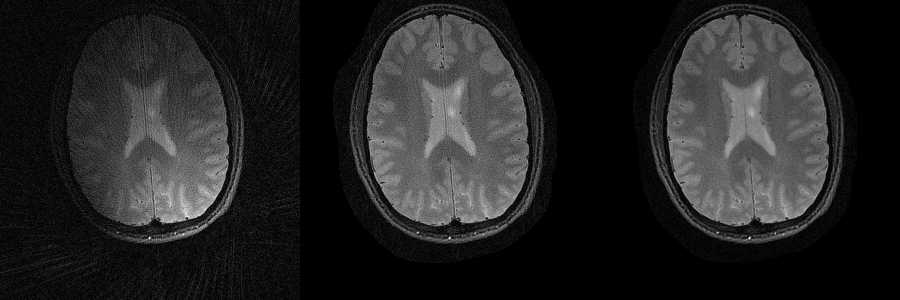

In [21]:
# Show together to create first line of the output figure:
imshow_mult brain_reconstruction/{nufft_adj_1_Coil0_flip,recon_pics_1_it1_flip,recon_pics_1_flip}

If you want to actually see all the details of reconstructing the different undersamplings and parsing the log files, my scripts are available in the recon/ subfolder.

## Exercise
Perform your reconstruction on undersampling factors of 3 (and  maybe 4) and vary the regularization!

What happens to a single step reconstruction of you do not use the Ram-Lak filter?

In [22]:
# Undersampling 3
./undersample.py 2 3 data/brain_radial_96proj_12ch_cfl/rawdata brain_reconstruction/rawdata_3
./undersample.py 2 3 data/brain_radial_96proj_12ch_cfl/trajectory brain_reconstruction/traj_3

bart extract 2 0 32 brain_reconstruction/rl_1 brain_reconstruction/rl_3
bart spow 0.5 brain_reconstruction/{,sqrt_}rl_3

bart fmac brain_reconstruction/{rl_3,rawdata_3,rawdata_rl_3}
bart nufft -a brain_reconstruction/{traj_3,rawdata_rl_3,nufft_adj_3}
bart flip 7 brain_reconstruction/nufft_adj_3{,_flip}

bart slice 3 0 brain_reconstruction/{nufft_adj_3_flip,nufft_adj_3_Coil0_flip}


bart pics -i1 -d5 -t brain_reconstruction/{traj_3,rawdata_3,Coils,recon_pics_3_noweight}
bart flip 7 brain_reconstruction/recon_pics_3_noweight{,_flip}

bart pics -T brain_reconstruction/recon_pics_1 -i30 -d5 -p brain_reconstruction/sqrt_rl_3 -RQ:0.1 -t brain_reconstruction/traj_3 \
brain_reconstruction/rawdata_3 brain_reconstruction/Coils \
brain_reconstruction/recon_pics_3
bart flip 7 brain_reconstruction/recon_pics_3{,_flip}


bart pics -T brain_reconstruction/recon_pics_1 -i1 -d5 -p brain_reconstruction/sqrt_rl_3 -RQ:0.1 -t brain_reconstruction/traj_3 \
brain_reconstruction/rawdata_3 brain_reconstruction/Coils \
brain_reconstruction/recon_pics_3_it1
bart flip 7 brain_reconstruction/recon_pics_3_it1{,_flip}

Est. image size: 300 300 1
Done.
[  1 512  32  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
[300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512  32  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  32   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 512  32   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512  32   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 16384 (vs. 376384) + 360000
ksp : [  1 512  32   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  32   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Linking args 1-2 of 4.
Linkin

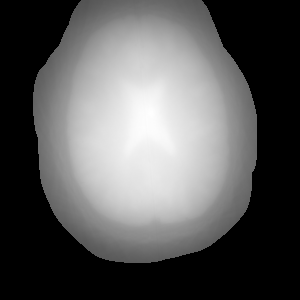

In [23]:
# With a Ram-Filter, convergence is slower. So the image after just a single cg step looks very blurry
imshow_nowin brain_reconstruction/recon_pics_3_noweight_flip

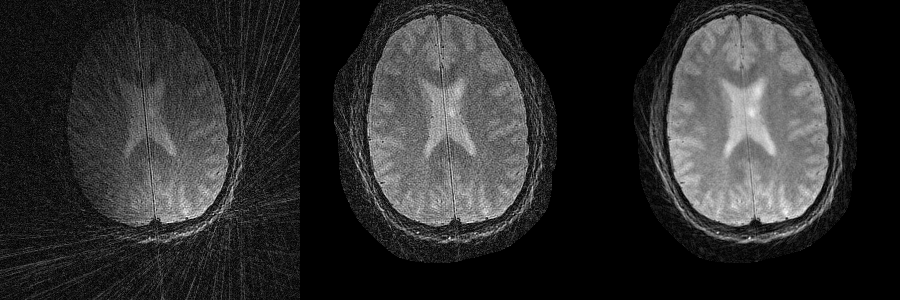

In [24]:
imshow_mult brain_reconstruction/{nufft_adj_3_Coil0_flip,recon_pics_3_it1_flip,recon_pics_3_flip}

In [25]:
# Undersampling 4
./undersample.py 2 4 data/brain_radial_96proj_12ch_cfl/rawdata brain_reconstruction/rawdata_4
./undersample.py 2 4 data/brain_radial_96proj_12ch_cfl/trajectory brain_reconstruction/traj_4

bart extract 2 0 24 brain_reconstruction/rl_1 brain_reconstruction/rl_4
bart spow 0.5 brain_reconstruction/{,sqrt_}rl_4

bart fmac brain_reconstruction/{rl_4,rawdata_4,rawdata_rl_4}
bart nufft -a brain_reconstruction/{traj_4,rawdata_rl_4,nufft_adj_4}
bart flip 7 brain_reconstruction/nufft_adj_4{,_flip}

bart slice 3 0 brain_reconstruction/{nufft_adj_4_flip,nufft_adj_4_Coil0_flip}


bart pics -T brain_reconstruction/recon_pics_1 -i30 -d5 -p brain_reconstruction/sqrt_rl_4 -RQ:0.1 -t brain_reconstruction/traj_4 \
brain_reconstruction/rawdata_4 brain_reconstruction/Coils \
brain_reconstruction/recon_pics_4
bart flip 7 brain_reconstruction/recon_pics_4{,_flip}


bart pics -T brain_reconstruction/recon_pics_1 -i1 -d5 -p brain_reconstruction/sqrt_rl_4 -RQ:0.1 -t brain_reconstruction/traj_4 \
brain_reconstruction/rawdata_4 brain_reconstruction/Coils \
brain_reconstruction/recon_pics_4_it1
bart flip 7 brain_reconstruction/recon_pics_4_it1{,_flip}

Est. image size: 300 300 1
Done.
Compare to truth
[  1 512  24  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
[300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512  24  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  24   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512  24   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 512  24   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512  24   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 12288 (vs. 372288) + 360000
ksp : [  1 512  24   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  24  

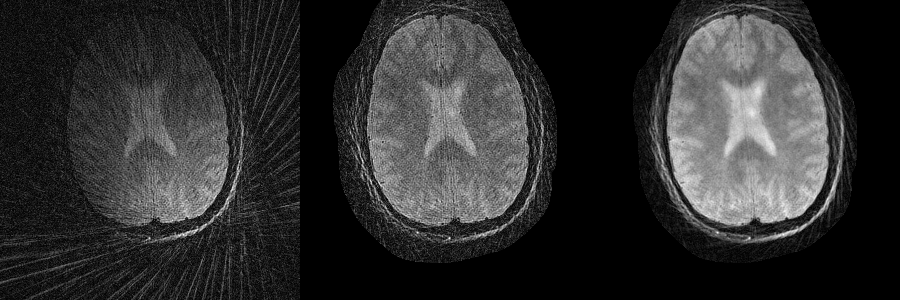

In [26]:
# Not much changes with undersampling of 4. Because we only have 24 spokes, the skull is no longer
# quite round, but instead becomes angled.
imshow_mult brain_reconstruction/{nufft_adj_4_Coil0_flip,recon_pics_4_it1_flip,recon_pics_4_flip}

In [27]:
# Use lower regularization for undersampling 4

bart pics -i30 -d1 -p brain_reconstruction/sqrt_rl_4 -RQ:1e-5 -t brain_reconstruction/traj_4 \
brain_reconstruction/rawdata_4 brain_reconstruction/Coils \
brain_reconstruction/recon_pics_4_reg_1e-5
bart flip 7 brain_reconstruction/recon_pics_4_reg_1e-5{,_flip}



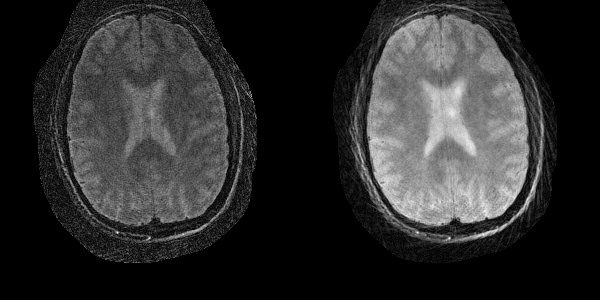

In [28]:
# Using much lower regularization (0.00001 vs 0.1), we get a much noisier reconstruction


imshow_mult brain_reconstruction/recon_pics_4_reg_1e-5_flip brain_reconstruction/recon_pics_4_flip